In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 320

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =1

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 20

data w_diffuse
     &     /1.6 , 1.8 , 1.8 , 1.8,
     &     1.7 , 1.6 , 1.4 , 1.4,
     &     1.7 , 1.8/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

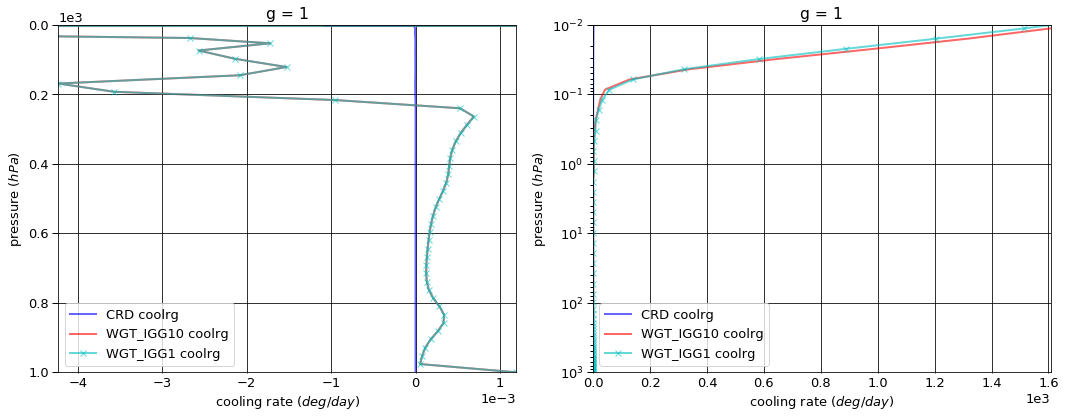

# Figure: cooling rate g-group 2

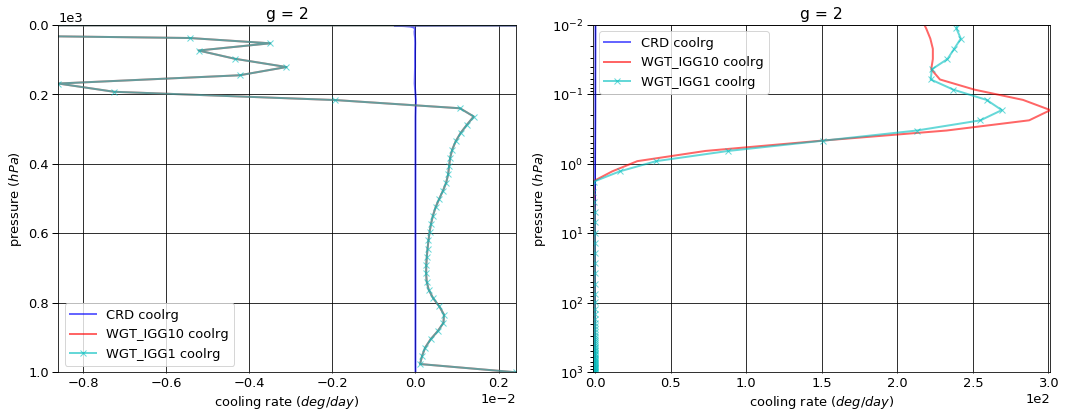

# Figure: cooling rate g-group 3

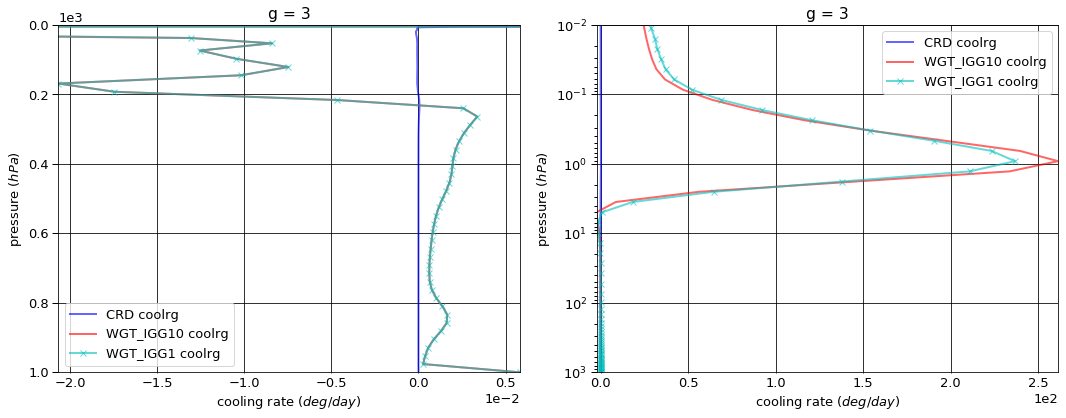

# Figure: cooling rate g-group 4

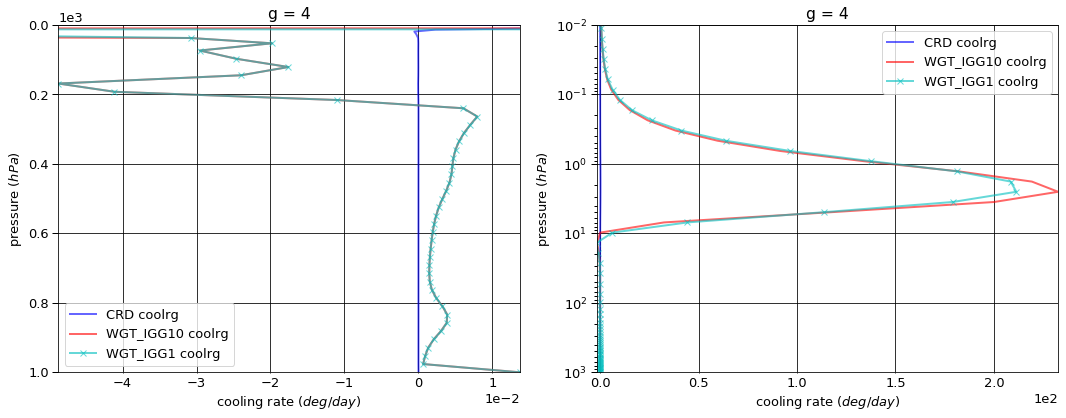

# Figure: cooling rate g-group 5

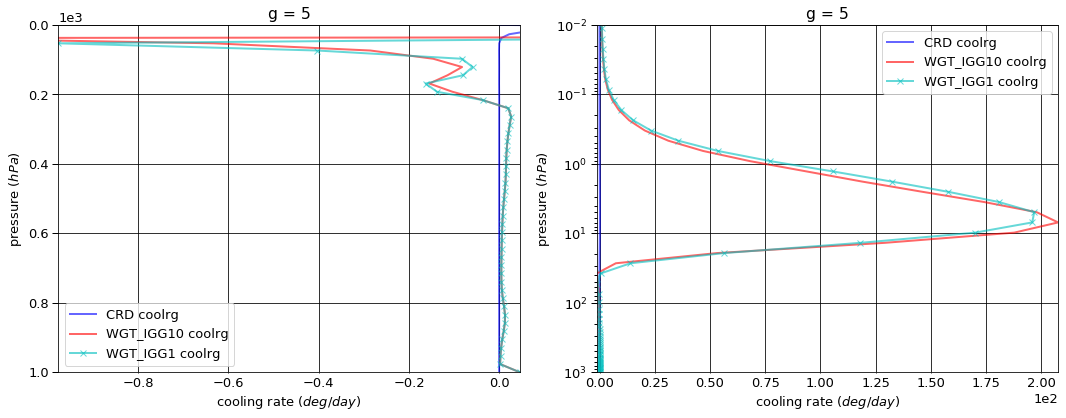

# Figure: cooling rate g-group 6

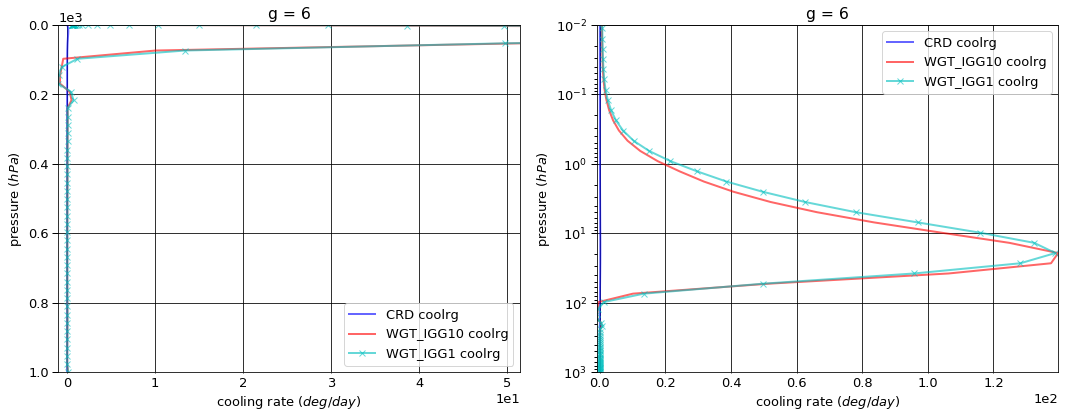

# Figure: cooling rate g-group 7

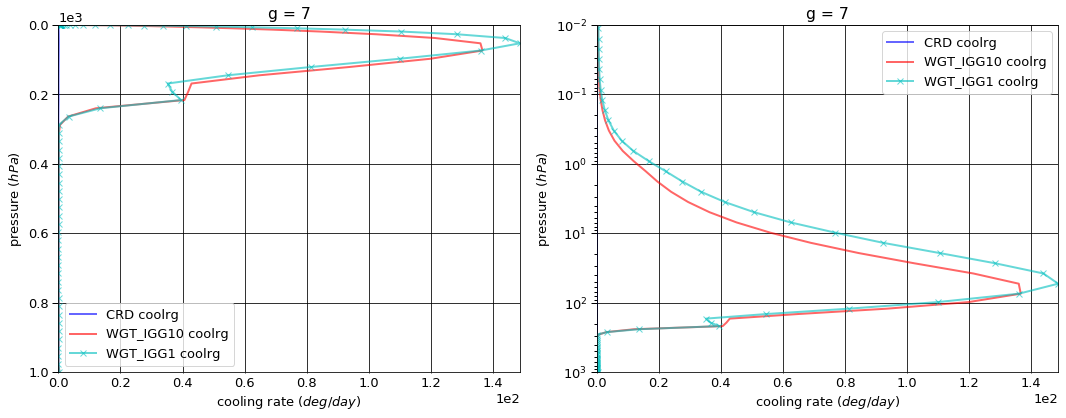

# Figure: cooling rate g-group 8

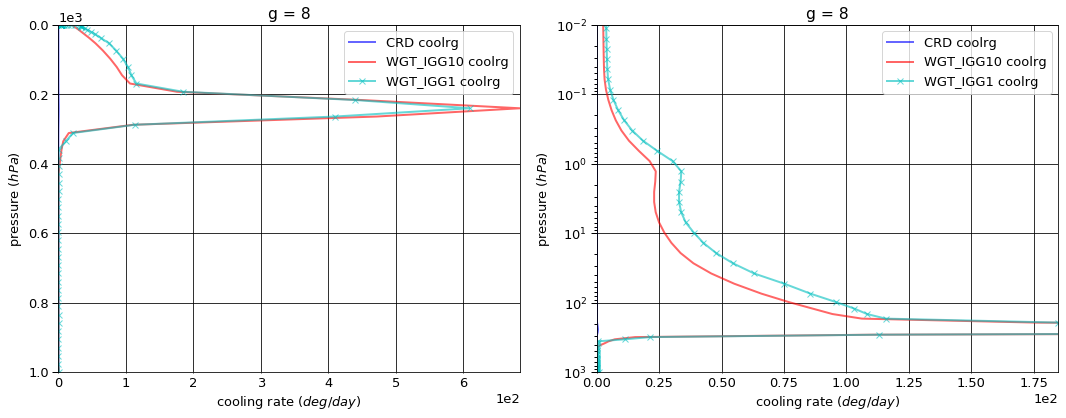

# Figure: cooling rate g-group 9

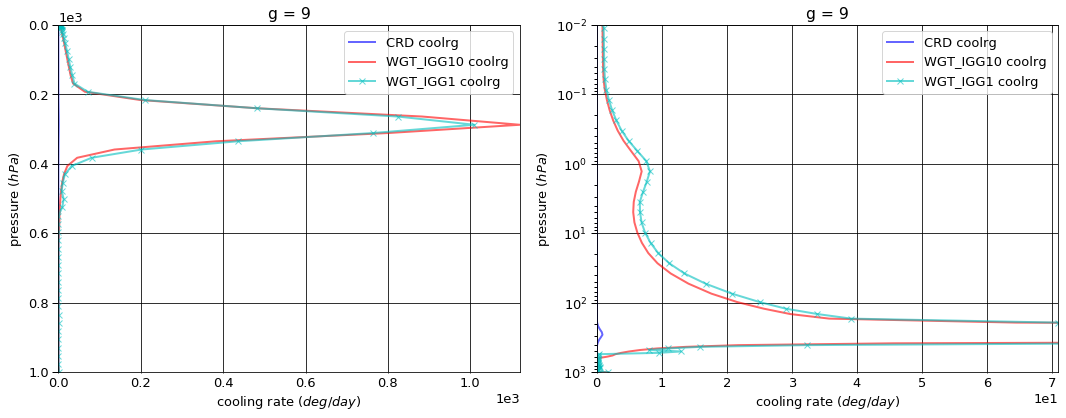

# Figure: cooling rate g-group 10

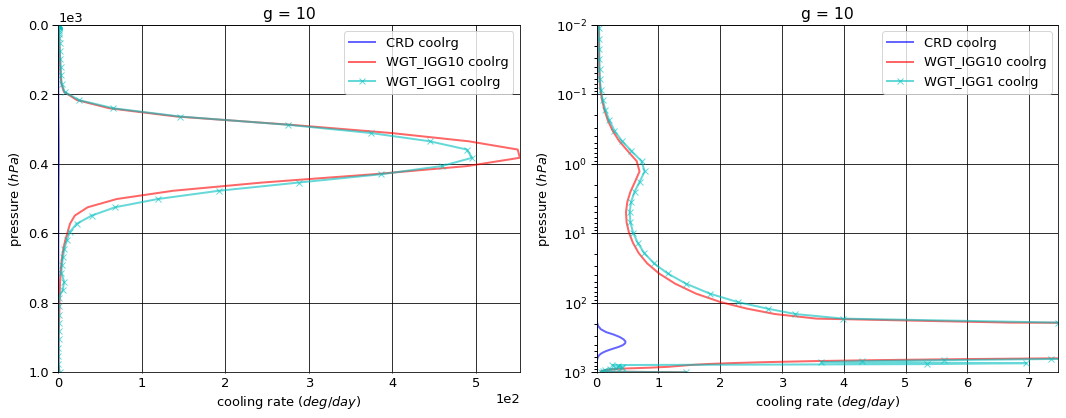

# Figure: cooling rate g-group total

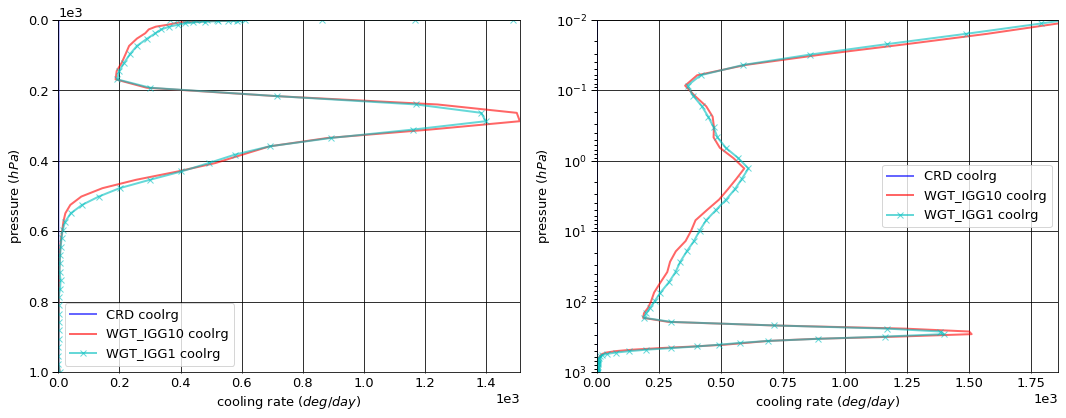

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007271   0.000000  -0.007271
   1013.0   76     -0.012460   0.012457  -0.000003
2  0.0      1      -0.017996   0.000000  -0.017996
   1013.0   76     -0.025527   0.025521  -0.000007
3  0.0      1      -0.050264   0.000000  -0.050264
   1013.0   76     -0.060809   0.060794  -0.000015
4  0.0      1      -0.113820   0.000000  -0.113820
   1013.0   76     -0.142595   0.142560  -0.000035
5  0.0      1      -0.339652   0.000000  -0.339652
   1013.0   76     -0.477034   0.476917  -0.000117
6  0.0      1      -0.717453   0.000000  -0.717453
   1013.0   76     -1.119475   1.119201  -0.000274
7  0.0      1      -2.367531   0.000000  -2.367531
   1013.0   76     -3.892565   3.891610  -0.000954
8  0.0      1      -7.049878   0.000000  -7.049878
   1013.0   76    -11.170086  11.167328  -0.002758
9  0.0      1     -12.381325   0.000000 -12.381325
   1013.0   76    -18.390455  18.385790  -0.004664
10 0.0      1     -11.186593   0.000000 -11.186593
   1013.0   76    -15.782424  15.777909  -0.004515


WGT_IGG10


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1         -7.073282      0.000000     -7.073282
   1013.0   76       -12.617462     12.614169     -0.003293
2  0.0      1        -17.757870      0.000000    -17.757870
   1013.0   76       -25.638538     25.631847     -0.006692
3  0.0      1        -51.326994      0.000000    -51.326994
   1013.0   76       -61.680713     61.664614     -0.016099
4  0.0      1       -115.992810      0.000000   -115.992810
   1013.0   76      -145.232420    145.194510     -0.037907
5  0.0      1       -340.790870      0.000000   -340.790870
   1013.0   76      -486.130350    486.003470     -0.126884
6  0.0      1       -709.288340      0.000000   -709.288340
   1013.0   76     -1141.387100   1141.089200     -0.297912
7  0.0      1      -2305.960100      0.000000  -2305.960100
   1013.0   76     -3966.410900   3965.375600     -1.035269
8  0.0      1      -6948.342300      0.000000  -6948.342300
   1013.0   76    -11356.659000  11353.695000     -2.964190
9  0.0      1     -12245.087000      0.000000 -12245.087000
   1013.0   76    -18550.441000  18545.599000     -4.841832
10 0.0      1     -11135.429000      0.000000 -11135.429000
   1013.0   76    -15327.232000  15323.231000     -4.000546


WGT_IGG1


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1         -7.081777      0.000000     -7.081777
   1013.0   76       -12.617462     12.614169     -0.003293
2  0.0      1        -17.968308      0.000000    -17.968308
   1013.0   76       -25.638538     25.631847     -0.006692
3  0.0      1        -51.015229      0.000000    -51.015229
   1013.0   76       -61.680713     61.664614     -0.016099
4  0.0      1       -115.251790      0.000000   -115.251790
   1013.0   76      -145.232420    145.194510     -0.037907
5  0.0      1       -340.281690      0.000000   -340.281690
   1013.0   76      -486.130350    486.003470     -0.126884
6  0.0      1       -711.339070      0.000000   -711.339070
   1013.0   76     -1141.387100   1141.089200     -0.297912
7  0.0      1      -2318.344800      0.000000  -2318.344800
   1013.0   76     -3966.410900   3965.375600     -1.035269
8  0.0      1      -6913.966100      0.000000  -6913.966100
   1013.0   76    -11356.659000  11353.695000     -2.964190
9  0.0      1     -12269.233000      0.000000 -12269.233000
   1013.0   76    -18550.441000  18545.599000     -4.841832
10 0.0      1     -11196.942000      0.000000 -11196.942000
   1013.0   76    -15327.232000  15323.231000     -4.000546


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1         -7.066011      0.000000     -7.066011
   1013.0   76       -12.605002     12.601712     -0.003290
2  0.0      1        -17.739874      0.000000    -17.739874
   1013.0   76       -25.613011     25.606326     -0.006685
3  0.0      1        -51.276730      0.000000    -51.276730
   1013.0   76       -61.619904     61.603820     -0.016084
4  0.0      1       -115.878990      0.000000   -115.878990
   1013.0   76      -145.089825    145.051950     -0.037872
5  0.0      1       -340.451218      0.000000   -340.451218
   1013.0   76      -485.653316    485.526553     -0.126768
6  0.0      1       -708.570887      0.000000   -708.570887
   1013.0   76     -1140.267625   1139.969999     -0.297639
7  0.0      1      -2303.592569      0.000000  -2303.592569
   1013.0   76     -3962.518335   3961.483990     -1.034315
8  0.0      1      -6941.292422      0.000000  -6941.292422
   1013.0   76    -11345.488914  11342.527672     -2.961432
9  0.0      1     -12232.705675      0.000000 -12232.705675
   1013.0   76    -18532.050545  18527.213210     -4.837168
10 0.0      1     -11124.242407      0.000000 -11124.242407
   1013.0   76    -15311.449576  15307.453091     -3.996031


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1         -7.074506      0.000000     -7.074506
   1013.0   76       -12.605002     12.601712     -0.003290
2  0.0      1        -17.950312      0.000000    -17.950312
   1013.0   76       -25.613011     25.606326     -0.006685
3  0.0      1        -50.964965      0.000000    -50.964965
   1013.0   76       -61.619904     61.603820     -0.016084
4  0.0      1       -115.137970      0.000000   -115.137970
   1013.0   76      -145.089825    145.051950     -0.037872
5  0.0      1       -339.942038      0.000000   -339.942038
   1013.0   76      -485.653316    485.526553     -0.126768
6  0.0      1       -710.621616      0.000000   -710.621616
   1013.0   76     -1140.267625   1139.969999     -0.297639
7  0.0      1      -2315.977269      0.000000  -2315.977269
   1013.0   76     -3962.518335   3961.483990     -1.034315
8  0.0      1      -6906.916222      0.000000  -6906.916222
   1013.0   76    -11345.488914  11342.527672     -2.961432
9  0.0      1     -12256.851675      0.000000 -12256.851675
   1013.0   76    -18532.050545  18527.213210     -4.837168
10 0.0      1     -11185.755407      0.000000 -11185.755407
   1013.0   76    -15311.449576  15307.453091     -3.996031

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer          
1  0.000312    1      4.811285
   1001.112500 75     0.000001
2  0.000312    1      0.322871
   1001.112500 75     0.000002
3  0.000312    1      0.053611
   1001.112500 75     0.000005
4  0.000312    1      0.000024
   1001.112500 75     0.000013
5  0.000312    1      0.000858
   1001.112500 75     0.000042
6  0.000312    1      0.000513
   1001.112500 75     0.000099
7  0.000312    1      0.000513
   1001.112500 75     0.000345
8  0.000312    1      0.003903
   1001.112500 75     0.000997
9  0.000312    1      0.001368
   1001.112500 75     0.001687
10 0.000312    1      0.000042
   1001.112500 75     0.001633


WGT_IGG10


coolrg
g  pressure    layer             
1  0.000312    1      2392.797300
   1001.112500 75        0.001191
2  0.000312    1       184.542260
   1001.112500 75        0.002420
3  0.000312    1        18.723187
   1001.112500 75        0.005821
4  0.000312    1         0.019053
   1001.112500 75        0.013707
5  0.000312    1         0.582458
   1001.112500 75        0.045880
6  0.000312    1         0.456881
   1001.112500 75        0.107722
7  0.000312    1         0.319885
   1001.112500 75        0.374344
8  0.000312    1         2.258910
   1001.112500 75        1.071824
9  0.000312    1         0.759001
   1001.112500 75        1.750762
10 0.000312    1         0.026373
   1001.112500 75        1.446561


WGT_IGG1


coolrg
g  pressure    layer             
1  0.000312    1      2912.155300
   1001.112500 75        0.001191
2  0.000312    1       214.344340
   1001.112500 75        0.002420
3  0.000312    1        22.756632
   1001.112500 75        0.005821
4  0.000312    1         0.020465
   1001.112500 75        0.013707
5  0.000312    1         0.640865
   1001.112500 75        0.045880
6  0.000312    1         0.542988
   1001.112500 75        0.107722
7  0.000312    1         0.443102
   1001.112500 75        0.374344
8  0.000312    1         3.272822
   1001.112500 75        1.071824
9  0.000312    1         0.915296
   1001.112500 75        1.750762
10 0.000312    1         0.030314
   1001.112500 75        1.446561


WGT_IGG10 - CRD


coolrg
g  pressure    layer             
1  0.000312    1      2387.986015
   1001.112500 75        0.001190
2  0.000312    1       184.219389
   1001.112500 75        0.002417
3  0.000312    1        18.669576
   1001.112500 75        0.005816
4  0.000312    1         0.019029
   1001.112500 75        0.013694
5  0.000312    1         0.581601
   1001.112500 75        0.045838
6  0.000312    1         0.456368
   1001.112500 75        0.107623
7  0.000312    1         0.319372
   1001.112500 75        0.373999
8  0.000312    1         2.255007
   1001.112500 75        1.070827
9  0.000312    1         0.757633
   1001.112500 75        1.749076
10 0.000312    1         0.026331
   1001.112500 75        1.444928


WGT_IGG1 - CRD


coolrg
g  pressure    layer             
1  0.000312    1      2907.344015
   1001.112500 75        0.001190
2  0.000312    1       214.021468
   1001.112500 75        0.002417
3  0.000312    1        22.703021
   1001.112500 75        0.005816
4  0.000312    1         0.020441
   1001.112500 75        0.013694
5  0.000312    1         0.640007
   1001.112500 75        0.045838
6  0.000312    1         0.542475
   1001.112500 75        0.107623
7  0.000312    1         0.442589
   1001.112500 75        0.373999
8  0.000312    1         3.268918
   1001.112500 75        1.070827
9  0.000312    1         0.913928
   1001.112500 75        1.749076
10 0.000312    1         0.030273
   1001.112500 75        1.444928

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.231785,0.000000,-34.231785
1013.0,76,-51.073430,51.060087,-0.013342



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33877.048566,0.00000,-33877.048566
1013.0,76,-51073.429483,51060.09841,-13.330625



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33941.423764,0.00000,-33941.423764
1013.0,76,-51073.429483,51060.09841,-13.330625



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33842.816781,0.000000,-33842.816781
1013.0,76,-51022.356053,51009.038323,-13.317283



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33907.191979,0.000000,-33907.191979
1013.0,76,-51022.356053,51009.038323,-13.317283


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,5.194989
1001.112500,75,0.004825



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2600.485309
1001.112500,75,4.820233



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,3155.122123
1001.112500,75,4.820233



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,2595.290320
1001.112500,75,4.815408



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,3149.927134
1001.112500,75,4.815408


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000266,0.000247
2,0.000500,0.000502
3,0.001391,0.001208
4,0.003156,0.002844
5,0.011406,0.009518
6,0.025547,0.022348
7,0.093094,0.077661
8,0.256141,0.222359
9,0.383641,0.363211


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.096164e-16
2,1.309690e-17
3,1.564810e-18
4,4.601703e-18
5,5.682550e-19
6,6.154553e-19
7,7.853808e-20
8,1.002222e-20
9,1.278933e-21


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.096164e-16,NaN,0.000266,0.000247,0.000266,0.000247,1.0
2,1.309690e-17,0.119479,0.000500,0.000502,0.000766,0.000749,1.0
3,1.564810e-18,0.119479,0.001391,0.001208,0.002156,0.001957,1.0
4,4.601703e-18,2.940742,0.003156,0.002844,0.005313,0.004800,30.0
5,5.682550e-19,0.123488,0.011406,0.009518,0.016719,0.014319,30.0
6,6.154553e-19,1.083062,0.025547,0.022348,0.042266,0.036667,300.0
7,7.853808e-20,0.127610,0.093094,0.077661,0.135359,0.114328,300.0
8,1.002222e-20,0.127610,0.256141,0.222359,0.391500,0.336687,300.0
9,1.278933e-21,0.127610,0.383641,0.363211,0.775141,0.699898,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     3.496473e-16  1.439570e-16   2.428832  1.751459e-02
      2  0.000312     1.249747e-17  7.846205e-18   1.592805  7.870240e-04
      3  0.000312     1.120215e-18  4.037302e-19   2.774663  5.268713e-05
      4  0.000312     2.343198e-22  2.341875e-22   1.000565  1.994706e-08
      5  0.000312     2.420018e-21  1.339821e-21   1.806224  1.416980e-07
      6  0.000312     5.901229e-22  4.407490e-22   1.338909  4.135095e-08
      7  0.000312     1.354900e-22  5.331447e-23   2.541336  8.739217e-09
      8  0.000312     4.270163e-22  3.437408e-23  12.422623  2.299005e-08
      9  0.000312     8.260202e-23  3.924228e-24  21.049239  4.354366e-09
      10 0.000312     3.811410e-24  3.445346e-25  11.062488  2.064868e-10
2     1  0.000750     3.501650e-16  1.442141e-16   2.428092  7.066144e-03
      2  0.000750     1.256808e-17  7.883427e-18   1.594240  3.186231e-04
      3  0.000750     1.124441e-18  4.067695e-19   2.764320  2.133814e-05
      4  0.000750     4.682076e-22  4.680672e-22   1.000300  1.605698e-08
      5  0.000750     2.455964e-21  1.373555e-21   1.788034  5.825395e-08
      6  0.000750     5.950202e-22  4.449604e-22   1.337243  1.680713e-08
      7  0.000750     1.366513e-22  5.400166e-23   2.530503  3.553371e-09
      8  0.000750     4.284447e-22  3.455798e-23  12.397849  9.292007e-09
      9  0.000750     8.288454e-23  3.947428e-24  20.997102  1.760014e-09
      10 0.000750     3.845785e-24  3.465013e-25  11.098906  8.390459e-11
3     1  0.001052     3.512557e-16  1.446637e-16   2.428085  9.940338e-03
      2  0.001052     1.270978e-17  7.947683e-18   1.599181  4.510411e-04
      3  0.001052     1.131591e-18  4.107535e-19   2.754916  3.016164e-05
      4  0.001052     6.298645e-22  6.297147e-22   1.000238  3.029416e-08
      5  0.001052     2.490704e-21  1.403785e-21   1.774277  8.321377e-08
      6  0.001052     6.010377e-22  4.494624e-22   1.337237  2.380851e-08
      7  0.001052     1.384202e-22  5.472986e-23   2.529152  5.048262e-09
      8  0.001052     4.313308e-22  3.479816e-23  12.395220  1.311890e-08
      9  0.001052     8.348035e-23  3.980100e-24  20.974436  2.486043e-09
      10 0.001052     3.918345e-24  3.494352e-25  11.213367  1.198173e-10
4     1  0.001476     3.524068e-16  1.451549e-16   2.427798  1.399173e-02
      2  0.001476     1.286234e-17  8.018129e-18   1.604158  6.391785e-04
      3  0.001476     1.139544e-18  4.153909e-19   2.743304  4.269359e-05
      4  0.001476     8.565970e-22  8.564299e-22   1.000195  5.779969e-08
      5  0.001476     2.534697e-21  1.442920e-21   1.756644  1.194793e-07
      6  0.001476     6.081527e-22  4.549653e-22   1.336701  3.380477e-08
      7  0.001476     1.404368e-22  5.562650e-23   2.524639  7.188026e-09
      8  0.001476     4.344564e-22  3.507775e-23  12.385525  1.853851e-08
      9  0.001476     8.412025e-23  4.017490e-24  20.938507  3.514569e-09
      10 0.001476     3.996838e-24  3.527726e-25  11.329784  1.713591e-10
5     1  0.002070     3.535557e-16  1.456718e-16   2.427070  1.969149e-02
      2  0.002070     1.301856e-17  8.092625e-18   1.608694  9.058752e-04
      3  0.002070     1.148084e-18  4.207131e-19   2.728900  6.047662e-05
      4  0.002070     1.174613e-21  1.174413e-21   1.000170  1.111683e-07
      5  0.002070     2.590406e-21  1.493656e-21   1.734272  1.725237e-07
      6  0.002070     6.164843e-22  4.616801e-22   1.335306  4.809562e-08
      7  0.002070     1.426766e-22  5.672813e-23   2.515095  1.025074e-08
      8  0.002070     4.376756e-22  3.539878e-23  12.364144  2.619685e-08
      9  0.002070     8.477119e-23  4.059456e-24  20.882402  4.968047e-09
      10 0.002070     4.077297e-24  3.564814e-25  11.437616  2.450559e-10
6     1  0.002904     3.547013e-16  1.462239e-16   2.425740  2.771894e-02
      2  0.002904     1.317924e-17  8.172731e-18   1.612586  1.284551e-03
      3  0.002904     1.157408e

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
